In [238]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [196]:
%R require(ggplot2)

/opt/intel/intelpython35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Carregando pacotes exigidos: ggplot2

  warnings.warn(x, RRuntimeWarning)


array([1], dtype=int32)

In [3]:
from daal.data_management import AOSNumericTable
from daal.data_management import SOANumericTable
from daal.data_management import BlockDescriptor_Intc
from daal.data_management import BlockDescriptor
from daal.data_management import BlockDescriptor_Float64
from daal.data_management import readOnly
from daal.data_management import readWrite
from daal.data_management import data_feature_utils
from daal.data_management import HomogenNumericTable
from daal.data_management import NumericTableIface
from daal.data_management import MergedNumericTable
from daal.data_management import FileDataSource
from daal.data_management import DataSourceIface
from daal.data_management import packed_mask

from daal.algorithms.linear_regression import training
from daal.algorithms.linear_regression import prediction


from daal import step1Local
from daal import step2Master


import numpy as np

</div>
    <h1>Leveraging Data Analytics with Intel DAAL</h1>
    <h3>Raphael Mendes de Oliveira Cóbe</h3>
    <p>rmcobe@ncc.unesp.br</p>
    <p>Source available on <a href="https://github.com/raphaelmcobe/intel-datascience-workshop">Github</a>

</div>
<div style="width:80%; margin-left:auto; margin-right:auto;">
    <img src=intel_logo.png style="height:170px; float:left;"/>
    <img src=ncc_logo.png style="height:170px; float:right;"/></div>
<div>

# NCC/Unesp

* GridUnesp
    * 256 WorkerNodes
    
* Sprace
    * Tier-2 Cern
    * 1PB Raw Data

# Data Science

* Recently open field that put together lots of concepts of other fields, such as:
  * Data Mining;
  * Data Cleaning;

# Intel Data Analytics Acceleration Library
* Delivers high application performance across spectrum of Intel®-architecture devices
* Speeds time-to-value through data source and environment integration 
* Reduces application development time via wide selection of pre-optimized advanced analytics algorithms

# Data Management

* Data Table
<center><img src="datatable.png" width=400 style="transform:rotate(90deg);"/></center>

# Data Management and Data Structures

* **Heterogeneous Tables** are used when there are multiple data types in a data set (e.g.double, string, etc.) 
    * Structures supported: **Structures of Arrays (SoA)** and **Arrays of Structures (AoS)**. 
* **Homogeneous Tables** are used when the data set has only one type of data. 
    * Two types of homogeneous tables: **dense** and **sparse**. 

# Data Management and Data Structures

* **Matrices** are used when the application requires matrix algebra type workloads
    * Three kinds of matrices supported: **dense matrix**, **packed symmetric matrix**, and **packed triangular matri-ces**. 




# AOS vs SOA

<center><img src="aos.png" style="height:220px;"/></center>
<center><img src="soa.png" style="height:320px;"/></center>

# Loading Data from a NumPy Array (AOS)

* Loading from a NumPy Array:

In [54]:
points = np.array([(0.5, -1.3, 1, 100.1),
                   (2.5, -3.3, 2, 200.2),
                   (4.5, -5.3, 2, 350.3),
                   (6.5, -7.3, 0, 470.4),
                   (8.5, -9.3, 1, 270.5)],
                  dtype=[('x','f4'), ('y','f4'), 
                         ('categ','i4'), ('value','f8')])  


dataTable = AOSNumericTable(points)    

# Retrieving values of a Feature
* By Column

In [53]:
nObservations = len(points)
nFeatures = len(points[0])
firstReadRow = 2
readFeatureIdx = 0

floatBlock = BlockDescriptor_Float64()
dataTable.getBlockOfColumnValues(readFeatureIdx, firstReadRow,
                                 nObservations, readOnly, floatBlock)
dataTable.releaseBlockOfColumnValues(floatBlock)
print(floatBlock.getArray())

[[ 4.5]
 [ 6.5]
 [ 8.5]]


# Retrieving values of a Feature
* By Rows

In [68]:
firstReadRow = 2
nRead = 3
doubleBlock = BlockDescriptor_Float64()
dataTable.getBlockOfRows(firstReadRow, nRead, readOnly, doubleBlock)

print("Block of Rows:")
print(doubleBlock.getArray())


Block of Rows:
[[  3.           3.29999995   1.4        -30.        ]
 [  4.           3.4000001    1.6        -40.        ]
 [  5.           3.5          1.8        -50.        ]]


# Loading Data from a NumPy Array (SOA)

In [33]:
def toString(v):
    if v == data_feature_utils.DAAL_CATEGORICAL:
        return "DAAL_CATEGORICAL"
    elif v == data_feature_utils.DAAL_ORDINAL:
        return "DAAL_ORDINAL"
    elif v == data_feature_utils.DAAL_CONTINUOUS:
        return "DAAL_CONTINUOUS"
    else:
        return "[Unknown FeatureType]"


In [57]:
nObservations = 10
nFeatures = 4

dDataSOA = np.array([1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8], dtype=np.float64)
fDataSOA = np.array([3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0], dtype=np.float32)
iDataSOA = np.array([-10, -20, -30, -40, -50, -60, -70, -80, -90, -100], dtype=np.int32)
cDataSOA = np.array([1, 2, 3, 4, 5, 1, 2, 3, 4, 5], dtype=np.uint8)

dataTable = SOANumericTable(nFeatures, nObservations)
dataTable.setArray(cDataSOA, 0)
dataTable.setArray(fDataSOA, 1)
dataTable.setArray(dDataSOA, 2)
dataTable.setArray(iDataSOA, 3)

# Setting and Retrieving data Types

* Setting datatypes:

In [80]:
dict = dataTable.getDictionary()
dict[0].featureType = data_feature_utils.DAAL_CONTINUOUS
dict[1].featureType = data_feature_utils.DAAL_CONTINUOUS
dict[2].featureType = data_feature_utils.DAAL_CONTINUOUS
dict[3].featureType = data_feature_utils.DAAL_CATEGORICAL

* Retrieving datatypes:

In [81]:
pDictionary = dataTable.getDictionary()
print("\nDataTypes:")
for i in range(0, nFeatures):
    featureType = pDictionary[i].featureType
    print("{}: {}".format(i, toString(featureType)), end=', ')



DataTypes:
0: DAAL_CONTINUOUS, 1: DAAL_CONTINUOUS, 2: DAAL_CONTINUOUS, 3: DAAL_CATEGORICAL, 

# Merging data

* `MergedNumericTable`




In [109]:
data1 = np.array([(0.0, 0.1, 0.2, 0.3, 0.4),
                  (1.0, 1.1, 1.2, 1.3, 1.4),
                  (2.0, 2.1, 2.2, 2.3, 2.4),
                  (3.0, 3.1, 3.2, 3.3, 3.4),
                  (4.0, 4.1, 4.2, 4.3, 4.4),])

data2 = np.array([(0.5, 0.6, 0.7, 0.8, 0.9, 1),
                  (1.5, 1.6, 1.7, 1.8, 1.9, 2),
                  (2.5, 2.6, 2.7, 2.8, 2.9, 3),
                  (3.5, 3.6, 3.7, 3.8, 3.9, 4),
                  (4.5, 4.6, 4.7, 4.8, 4.9, 5),])


dataTable1 = HomogenNumericTable(data1)
dataTable2 = HomogenNumericTable(data2)

dataTable = MergedNumericTable()
dataTable.addNumericTable(dataTable1)
dataTable.addNumericTable(dataTable2)

# Merging data

* Modifying data

In [114]:
nFeatures1 = 5
nFeatures2 = 6
firstReadRow = 3
nRead = 1


block = BlockDescriptor_Float64()
dataTable.getBlockOfRows(firstReadRow, nRead, readWrite, block)
print(block.getArray().flatten())

selected_row = block.getArray()
for i in range(0,len(selected_row[0])):
    selected_row[0][i] = 10
    
print(block.getArray())
dataTable.releaseBlockOfRows(block)



[ 3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4. ]
[[ 10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.]]


# Merging data

* Modifying data (2)

In [116]:
dataTable1.getBlockOfRows(firstReadRow, nRead, readOnly, block)
print(block.getArray())
dataTable1.releaseBlockOfRows(block)

dataTable2.getBlockOfRows(firstReadRow, nRead, readOnly, block)
print(block.getArray())
dataTable2.releaseBlockOfRows(block)

[[ 10.  10.  10.  10.  10.]]
[[ 10.  10.  10.  10.  10.  10.]]


# Reading from CSV files

In [176]:
nFeatures = 4
nOutcomes = 1

trainDatasetFileName = './housing-train.csv'

trainDataSource = FileDataSource(trainDatasetFileName, 
                                 DataSourceIface.notAllocateNumericTable,
                                 DataSourceIface.doDictionaryFromContext)

trainData = HomogenNumericTable(nFeatures, 0, NumericTableIface.notAllocate)
trainOutcome = HomogenNumericTable(nOutcomes, 0, NumericTableIface.notAllocate)

mergedData = MergedNumericTable(trainOutcome, trainData)

nObservations = trainDataSource.loadDataBlock(mergedData)

print("Observations read: {}".format(nObservations))


Observations read: 435


# Prediction

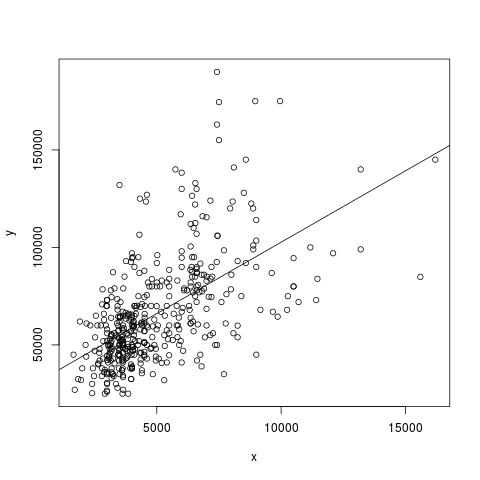

In [213]:
%%R 
dataset <- read.csv('housing-train.csv')
y <- dataset[,1]
x <- dataset[,2]
plot(x,y)
abline(lm(y~x))

# Linear Regression

* Tries to fit a linear function to the data;
* Helps visualizing some data behaviours;

<center><img src="lm.png" style="padding-top:30px;"/></center>

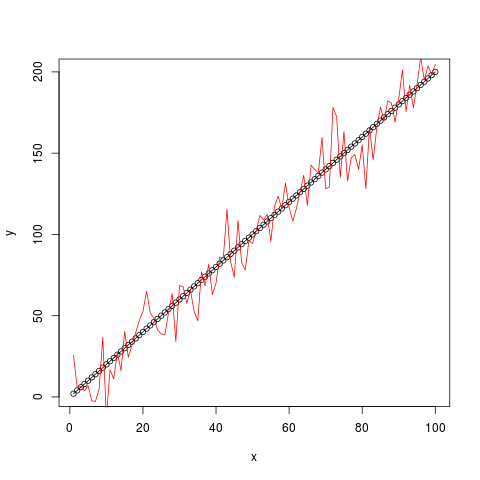

In [216]:
%%R
x <- 1:100
y <- x*2
plot(x,y)
lines(y)
z = y+(rnorm(length(y))*10)
lines(z, col="red")

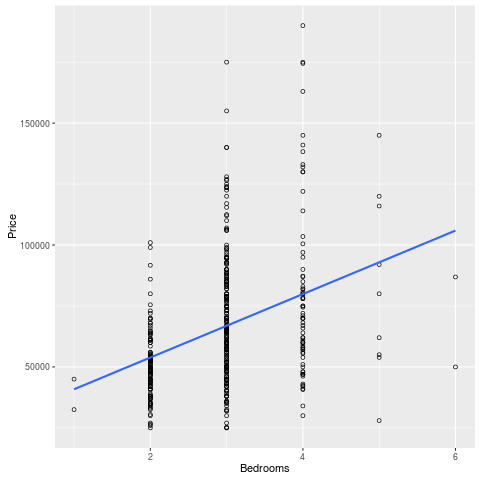

In [237]:
%%R
dataset <- read.csv('./housing-train.csv')
p <- ggplot(dataset, aes(x=dataset[,3], y=dataset[,1])) +
    geom_point(shape=1) + geom_smooth(method=lm, se=FALSE)
print(p + xlab("Bedrooms")+ylab("Price"))

# Why use it?

* Questions we may answer:
    * Is there a relationship between house pricing and the house size?

<center><img src="lm4.png" style="height:450px;"/></center>

# Why use it?

* Questions we may answer:
    * Is there a relationship between house pricing and the number of bedrooms?

<center><img src="lm3.png" style="height:450px;"/></center>

# Regression Problems

* Data set where a **right answer** is given as input to the problem
    * **We know actual prices for houses**
    * Learn what makes the price a certain value from the training data;
    * More right answers based on new training data where we don't know the price already.
* We also call this a regression problem
    * Predict continuous valued output (price)
    * No real discrete delineation 

# The math behind it

* Assume that there is a dependency between variables;
    * More specifically, $Y$ depends *linearly* on $X_1, X_2, X_3, X_n$
    * In most real world data, <font color='red'>regression is never Linear</font>;
<center><img src="lm2.png" style="padding-top:30px;"/></center>    


# The math behind it

* Given samples $(x_i,y_i)$ where $1 \leq i \leq n$
    * Predict $y_{i+1}$ given the new information $x_{i+1}$
* We assume that the data can be modeled with the following: $Y = \theta_0 + \theta_1X +\epsilon$ where
    * $\theta_0$ is the **intercept**
    * $\theta_1$ is the **slope**
* Given some estimates $\theta_0$ and $\theta_1$ for the model coeficients, we predict future $y$ values using: $\hat{y} = \theta_0+\theta_1x$
* The *ith* residual: $\epsilon_i = y_i - \hat{y}_i$
* A hypothesis takes in some variable;
* Uses parameters determined by a learning system
* Outputs a prediction based on that input

# The math behind it

* If $\theta_1 \geq 0$ then we get a positive slope;
* If $\theta_0 = 1.5$ and $\theta_1 = 0$ then we get straight line parallel with axis X along 1.5;
* The **squared error** is thus: $E=\sum_{i=1}^{m}(\hat{y}_i - y_i)^2$
* We face a **Minimization Problem**

# The math behind it

* Derivatives for minimization.
* Mean Squared Error: $E=\sum_{i=1}^{m}(\hat{y}_i - \theta_1x_i)^2$
    * Simplify $\theta_0 = 0$<br />
    <center>
$\frac{\partial E}{\partial\theta_1} = -2\sum_{i=1}^{m}x_i(\hat{y}_i - \theta_1x_i) = 0$<br />
</center>
<center>
$\sum_{i=1}^{m}x_iy_i = \theta_1\sum_{i=1}^{m}x_i^2$<br />
</center>
<center>
$\theta_1 = \frac{\sum_{i=1}^{m}x_iy_i}{\sum_{i=1}^{m}x_i^2}$
</center>

# The math behind it

## Multivariate Regression

* Given samples $(x_i,y_i)$ where $1 \leq i \leq n$
    * Predict $y_{i+1}$ given the new information $x_{i+1}$
* We assume that the data can be modeled with the following: $Y = \theta_0 + \theta_1X $ where
    * \theta_0 is the **intercept**
    * \theta_1 is the **slope**
$$
\beta_0=
\begin{bmatrix}
1\\
1\\
1\\
...\\
1\\
\end{bmatrix}
,\ \beta_1=
\begin{bmatrix}
\theta_1\\
\theta_2\\
\theta_3\\
...\\
\theta_n\\
\end{bmatrix}
,\ X=
\begin{bmatrix}
x_1\\
x_2\\
x_3\\
...\\
x_n\\
\end{bmatrix}
,\ and\ Y=
\begin{bmatrix}
y_1\\
y_2\\
y_3\\
...\\
y_n\\
\end{bmatrix}
$$

* Thus, we obtain $y_i$ in terms of $\theta_1, \theta_2, \theta_3, ..., \theta_n$ and $x_1, x_2, x_3, ..., x_n$:
$$
y_1 = \theta_0 + \theta_1x_1+\theta_2x_2+\theta_3x_3+ ...+ \theta_nx_n
$$
then:
$$
Y=\theta^TX
$$

# Training the Model

In [4]:
def printNumericTable(data_table, message='', num_printed_rows=0, num_printed_cols=0,
                      interval=10):
    num_rows = data_table.getNumberOfRows()
    num_cols = data_table.getNumberOfColumns()
    layout = data_table.getDataLayout()

    if num_printed_rows != 0:
        num_printed_rows = min(num_rows, num_printed_rows)
    else:
        num_printed_rows = num_rows

    if num_printed_cols != 0:
        num_printed_cols = min(num_cols, num_printed_cols)
    else:
        num_printed_cols = num_cols

    block = BlockDescriptor()
    if isFull(layout) or layout == NumericTableIface.csrArray:
        data_table.getBlockOfRows(0, num_rows, readOnly, block)
        printArray(block.getArray(), num_printed_cols, num_printed_rows,
                   num_cols, message, interval)
        data_table.releaseBlockOfRows(block)
    else:
        packed_table = data_table.getBlockOfRowsAsDouble(0, num_rows)

        if isLower(layout):
            printLowerArray(packed_table, num_printed_rows, message, interval)
        elif isUpper(layout):
            printUpperArray(packed_table, num_printed_cols, num_printed_rows,
                            num_cols, message, interval)
        
def isFull(layout):
    layout_int = int(layout)
    if packed_mask & layout_int:
        return False
    return True


def printArray(array, num_printed_cols, num_printed_rows, num_cols, message,
               interval=10, flt64=True):
    print(message)
    flat_array = array.flatten()
    decimals = '3' if flt64 else '0'
    for i in range(num_printed_rows):
        for j in range(num_printed_cols):
            print("{:<{width}.{dec}f}".format(
                flat_array[i * num_cols + j], width=interval, dec=decimals), end=''
            )
        print()
    print()


In [178]:
algorithm = training.Batch_Float64NormEqDense()
                                                                                                   
algorithm.input.set(training.data, trainData)
algorithm.input.set(training.dependentVariables, trainOutcome)
                                                                                                   
trainingResult = algorithm.compute()
printNumericTable(trainingResult.get(training.model).getBeta(), "Linear Regression coefficients:")


Linear Regression coefficients:
-6356.393 6.127     2760.738  16551.026 7322.687  



# Testing your model

In [7]:
testDatasetFileName = './housing-test.csv'

testDataSource = FileDataSource(
    testDatasetFileName, DataSourceIface.doAllocateNumericTable,
    DataSourceIface.doDictionaryFromContext
)

testData = HomogenNumericTable(nFeaturs    0, NumericTableIface.notAllocate)
testGroundTruth = HomogenNumericTable(nOutcomes, 0, NumericTableIface.notAllocate)
mergedData = MergedNumericTable(testGroundTruth,testData)

testDataSource.loadDataBlock(mergedData)

algorithm = prediction.Batch()

algorithm.input.setTable(prediction.data, testData)
algorithm.input.setModel(prediction.model, trainingResult.get(training.model))

predictionResult = algorithm.compute()  

# Testing your Model

In [241]:
printNumericTable(predictionResult.get(prediction.prediction), 
                  "Linear Regression prediction results: (first 10 rows):", 10)
printNumericTable(testGroundTruth, "Ground truth (first 10 rows):", 10)

Linear Regression prediction results: (first 10 rows):
77584.291 
97463.689 
54689.190 
65962.833 
75165.556 
47366.503 
55175.751 
47366.503 
62841.671 
65407.807 

Ground truth (first 10 rows):
75000.000 
132000.000
60000.000 
65000.000 
69000.000 
51900.000 
57000.000 
65000.000 
79500.000 
72500.000 



# Why Use it?

* Modes: 
    * **Batch**: the only compute method of a particular algorithm class is used; 
    * **Online**: this computation mode assumes that the data arrives in blocks;
        * `compute()` method each time new input becomes available.
        * When the last block of data arrives, call the `finalizeCompute()` method to produce final results;

# Why Use it?
* Modes:
    * **Distributed**: data sets distributed across several devices;
        * Assumes that the data set is split in *nblocks* blocks across computation nodes.
        * define the computation step for an algorithm; 

# Why Use it? Distributed!

* Provide the `computeStep` value to the constructor during initialization of the algorithm;
* Use the `compute()` method on each computation node (partial results)
* Provide the computeStep value to the constructor during initialization of the algorithm;
* Use the `compute()` method on each computation node (partial results)

# Distributed processing

<center><img src="distributed.png" style="padding-top:40px; height:650px;"/></center>

# Distributed processing

<center><img src="distributed2.png" style="padding-top:40px; height:650px;"/></center>

# Multiple inputs - splitting

In [12]:
nBlocks = 2
nFeatures = 4
nOutcomes = 1

trainDatasetFileNames = ['./housing-distributed-train1.csv', './housing-distributed-train2.csv']

masterAlgorithm = training.Distributed(step2Master)

for i in range(nBlocks):
    trainDataSource = FileDataSource(trainDatasetFileNames[i], DataSourceIface.notAllocateNumericTable,
                                     DataSourceIface.doDictionaryFromContext)
    trainData = HomogenNumericTable(nFeatures, 0, NumericTableIface.notAllocate)
    trainOutcome = HomogenNumericTable(nOutcomes, 0, NumericTableIface.notAllocate)
    mergedData = MergedNumericTable(trainOutcome, trainData)
    nObservations = trainDataSource.loadDataBlock(mergedData)
    print("Observations read on file {}: {}".format((i+1), nObservations))
    localAlgorithm = training.Distributed(step1Local)
    localAlgorithm.input.set(training.data, trainData)    
    localAlgorithm.input.set(training.dependentVariables, trainOutcome)
    partialResult = localAlgorithm.compute()
    masterAlgorithm.input.add(training.partialModels, partialResult)

Observations read on file 1: 215
Observations read on file 2: 220


# Multiple input - merging results

In [6]:
masterAlgorithm.compute()

trainingResult = masterAlgorithm.finalizeCompute()
printNumericTable(trainingResult.get(training.model).getBeta(), "Linear Regression coefficients:")

Linear Regression coefficients:
-6356.393 6.127     2760.738  16551.026 7322.687  



# Testing your model

In [10]:
testDatasetFileName = './housing-test.csv'

testDataSource = FileDataSource(
    testDatasetFileName, DataSourceIface.doAllocateNumericTable,
    DataSourceIface.doDictionaryFromContext
)

testData = HomogenNumericTable(nFeatures, 0, NumericTableIface.notAllocate)
testGroundTruth = HomogenNumericTable(nOutcomes, 0, NumericTableIface.notAllocate)
mergedData = MergedNumericTable(testGroundTruth,testData)

testDataSource.loadDataBlock(mergedData)

algorithm = prediction.Batch()

algorithm.input.setTable(prediction.data, testData)
algorithm.input.setModel(prediction.model, trainingResult.get(training.model))

predictionResult = algorithm.compute()

# Testing your model

In [11]:
printNumericTable(predictionResult.get(prediction.prediction), 
                  "Linear Regression prediction results: (first 10 rows):", 10)
printNumericTable(testGroundTruth, "Ground truth (first 10 rows):", 10)

Linear Regression prediction results: (first 10 rows):
77584.291 
97463.689 
54689.190 
65962.833 
75165.556 
47366.503 
55175.751 
47366.503 
62841.671 
65407.807 

Ground truth (first 10 rows):
75000.000 
132000.000
60000.000 
65000.000 
69000.000 
51900.000 
57000.000 
65000.000 
79500.000 
72500.000 




# What is included?

* Algorithms for:
    * **Pre-processing**, **Transformation**, **Analysis**, **Modeling**.

<center><img src="intel-daal-all-data-analysis-stages.png"/></center>

# Any questions?